In [91]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization

In [92]:
# Parameters
img_height, img_width = 48, 48  # FER2013 images are 48x48 pixels
batch_size = 64
channels = 3  
classes = 7 
data_dir = "/kaggle/input/fer2013"

In [93]:
# Load the FER2013 dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    color_mode='grayscale',  # Since FER2013 is grayscale
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    color_mode='grayscale',
    batch_size=batch_size
)

Found 35887 files belonging to 2 classes.
Using 28710 files for training.
Found 35887 files belonging to 2 classes.
Using 7177 files for validation.


In [94]:
# Convert grayscale images to RGB by repeating the single channel 3 times
def convert_to_rgb(image, label):
    image = tf.image.grayscale_to_rgb(image)
    return image, label

train_ds = train_ds.map(convert_to_rgb)
val_ds = val_ds.map(convert_to_rgb)

In [95]:
# Normalize pixel values to be between 0 and 1
normalization_layer = layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

In [96]:
# Define the input shape
input_shape = (img_height, img_width, channels)

In [97]:
# Load EfficientNetB0 with pre-trained weights, without the top layer
model_ENB0 = EfficientNetB0(include_top=False, weights='imagenet', input_shape=input_shape)

# Set all layers as non-trainable initially
model_ENB0.trainable = True
set_trainable = False

for layer in model_ENB0.layers:
    if layer.name == 'block6d_se_excite':
        set_trainable = True
    if set_trainable:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = True
        else:
            layer.trainable = False
    else:
        layer.trainable = False

In [98]:
# Build the final model
model = Sequential([
    model_ENB0,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(7, activation='softmax')  # For 7 emotion classes
])

In [99]:
# Define a learning rate scheduler callback
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return float(lr * tf.math.exp(-0.1))  # Convert to float

lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [100]:
# Compile the model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(learning_rate=1e-3),
              metrics=['accuracy'])

In [101]:
# Provide input shape by calling model with dummy data to build it
import numpy as np
dummy_input = np.zeros((1, img_height, img_width, channels))
model(dummy_input)

<tf.Tensor: shape=(1, 7), dtype=float32, numpy=
array([[0.15808956, 0.15572856, 0.13134935, 0.12957266, 0.16809285,
        0.1051731 , 0.15199399]], dtype=float32)>

In [102]:
# Print model summar
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (1, 2, 2, 1280)        │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_7      │ (1, 1280)              │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (1, 1280)              │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (1, 1280)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (1, 256)               │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (1, 256)               │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (1, 256)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (1, 7)                 │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,385,450 (16.73 MB)

 Trainable params: 1,675,575 (6.39 MB)

 Non-trainable params: 2,709,875 (10.34 MB)

In [103]:
# Train the model with the learning rate scheduler
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    batch_size=batch_size,
    verbose=1,
    callbacks=[lr_callback],
    shuffle=True
)

Epoch 1/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 61s 71ms/step - accuracy: 0.5077 - loss: 1.6627 - val_accuracy: 0.8001 - val_loss: 0.5251 - learning_rate: 0.0010
Epoch 2/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.7901 - loss: 0.5580 - val_accuracy: 0.8001 - val_loss: 0.5080 - learning_rate: 0.0010
Epoch 3/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.7996 - loss: 0.5187 - val_accuracy: 0.8001 - val_loss: 0.5408 - learning_rate: 0.0010
Epoch 4/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.8017 - loss: 0.5097 - val_accuracy: 0.8001 - val_loss: 0.5023 - learning_rate: 0.0010
Epoch 5/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.8025 - loss: 0.5061 - val_accuracy: 0.8001 - val_loss: 0.5010 - learning_rate: 0.0010
Epoch 6/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.8017 - loss: 0.5060 - val_accuracy: 0.8001 - val_loss: 0.5021 - learning_rate: 0.0010
Epoch 7/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.8031 - loss: 

In [104]:
# Access final training and validation accuracies
final_train_accuracy = history.history['accuracy'][-1]
final_val_accuracy = history.history['val_accuracy'][-1]

print(f"Final Training Accuracy: {final_train_accuracy:.4f}")
print(f"Final Validation Accuracy: {final_val_accuracy:.4f}")

Final Training Accuracy: 0.8000
Final Validation Accuracy: 0.8001


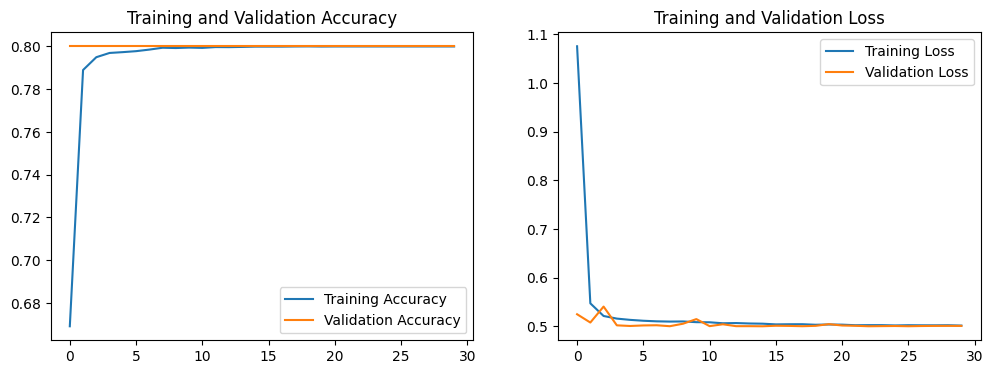

In [105]:
# Plot training and validation accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [106]:
# Save the model in HDF5 format with a custom name
model.save('attendance_emotion_detection_model.h5')